# Final Project --- Sonia Yuxiao Lai

In [1]:
import numpy as np
import sympy as sym
from sympy import Function, Matrix, solve, symbols, Eq
from sympy import cos, sin, pi
from numpy import dot

import matplotlib.pyplot as plt
import plotly

In [2]:
def animate(traj,L=1, W=0.2, R=0.1, T=10):

    ################################
    # Imports required for animation.
    from plotly.offline import init_notebook_mode, iplot
    from IPython.display import display, HTML
    import plotly.graph_objects as go

    #######################
    # Browser configuration.
    def configure_plotly_browser_state():
        import IPython
        display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
            <script>
              requirejs.config({
                paths: {
                  base: '/static/base',
                  plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
                },
              });
            </script>
            '''))
    configure_plotly_browser_state()
    init_notebook_mode(connected=False)

    ###############################################
    # Getting data from pendulum angle trajectories.
    xxb = traj[0]
    yyb = traj[1]
    thetab= traj[2]
    xxj = traj[3]
    yyj = traj[4]
    thetaj= traj[5]
    N = len(traj[0]) # Need this for specifying length of simulation

    ###############################################
    # Use homogeneous tranformation to transfer these two axes/points
    # back to the fixed frame
    frame_b1 = np.zeros((2,N))
    frame_b2 = np.zeros((2,N))
    frame_b3 = np.zeros((2,N))
    frame_b4 = np.zeros((2,N))
    frame_c11 = np.zeros((2,N))
    frame_c12 = np.zeros((2,N))
    frame_c13 = np.zeros((2,N))
    frame_c14 = np.zeros((2,N))
    frame_c21 = np.zeros((2,N))
    frame_c22 = np.zeros((2,N))
    frame_c23 = np.zeros((2,N))
    frame_c24 = np.zeros((2,N))
    xx1=np.zeros(N)
    yy1=np.zeros(N)
    xx2=np.zeros(N)
    yy2=np.zeros(N)
    xx3=np.zeros(N)
    yy3=np.zeros(N)
    xx4=np.zeros(N)
    yy4=np.zeros(N)

    for i in range(N): # iteration through each time step
        # --- evaluate homogeneous transformation transformation for the box -----
        t_wg = g_np(0, xxb[i], yyb[i])
        t_gh = g_np(thetab[i], 0, 0)
        t_hb1 = g_np(0, -L_box/2, L_box/2)
        t_hb2 = g_np(0, L_box/2, L_box/2)
        t_hb3 = g_np(0, L_box/2, -L_box/2)
        t_hb4 = g_np(0, -L_box/2, -L_box/2)
        
        # transformation for the four corners of rod 1
        t_wa = g_np(0, xxj[i], yyj[i])
        t_ab1 = g_np(thetaj[i], 0, 0)
        t_bc11 = g_np(0, -W/2, L/2)
        t_bc12 = g_np(0, W/2, L/2)
        t_bc13 = g_np(0, W/2, -L/2)
        t_bc14 = g_np(0, -W/2, -L/2)
        
        t_wc11 = np.linalg.multi_dot([t_wa, t_ab1, t_bc11])
        t_wc12 = np.linalg.multi_dot([t_wa, t_ab1, t_bc12])
        t_wc13 = np.linalg.multi_dot([t_wa, t_ab1, t_bc13])
        t_wc14 = np.linalg.multi_dot([t_wa, t_ab1, t_bc14])
        
        # transformation for the four corners of rod 2
        t_ab2 = g_np(thetaj[i]+np.pi/2, 0, 0)
        t_bc21 = g_np(0, -W/2, L/2)
        t_bc22 = g_np(0, W/2, L/2)
        t_bc23 = g_np(0, W/2, -L/2)
        t_bc24 = g_np(0, -W/2, -L/2)
        
        t_wb1 = np.linalg.multi_dot([t_wg, t_gh, t_hb1])
        t_wb2 = np.linalg.multi_dot([t_wg, t_gh, t_hb2])
        t_wb3 = np.linalg.multi_dot([t_wg, t_gh, t_hb3])
        t_wb4 = np.linalg.multi_dot([t_wg, t_gh, t_hb4])
        t_wc21 = np.linalg.multi_dot([t_wa, t_ab2, t_bc21])
        t_wc22 = np.linalg.multi_dot([t_wa, t_ab2, t_bc22])
        t_wc23 = np.linalg.multi_dot([t_wa, t_ab2, t_bc23])
        t_wc24 = np.linalg.multi_dot([t_wa, t_ab2, t_bc24])
        
        # transformation for the four spheres
        t_b1e = g_np(0, L/2+(2*R), 0)
        t_b1f = g_np(0, -L/2-(2*R), 0)
        t_b2c = g_np(0, -L/2-(2*R), 0)
        t_b2d = g_np(0, L/2+(2*R), 0)

        t_we = np.linalg.multi_dot([t_wa, t_ab1, t_b1e])
        t_wf = np.linalg.multi_dot([t_wa, t_ab1, t_b1f])
        t_wc = np.linalg.multi_dot([t_wa, t_ab2, t_b2c])
        t_wd = np.linalg.multi_dot([t_wa, t_ab2, t_b2d])

        # -------- transfer the x and y axes in body frame back to 
        # fixed frame at the current time step ---------
        # location of box in world frame
        frame_b1[:,i] = t_wb1.dot([0, 0, 0, 1])[0:2]
        frame_b2[:,i] = t_wb2.dot([0, 0, 0, 1])[0:2]
        frame_b3[:,i] = t_wb3.dot([0, 0, 0, 1])[0:2]
        frame_b4[:,i] = t_wb4.dot([0, 0, 0, 1])[0:2]
        
        # location of rod 1 in world frame
        frame_c11[:,i] = t_wc11.dot([0, 0, 0, 1])[0:2]
        frame_c12[:,i] = t_wc12.dot([0, 0, 0, 1])[0:2]
        frame_c13[:,i] = t_wc13.dot([0, 0, 0, 1])[0:2]
        frame_c14[:,i] = t_wc14.dot([0, 0, 0, 1])[0:2]
        
        # location of rod 2 in world frame
        frame_c21[:,i] = t_wc21.dot([0, 0, 0, 1])[0:2]
        frame_c22[:,i] = t_wc22.dot([0, 0, 0, 1])[0:2]
        frame_c23[:,i] = t_wc23.dot([0, 0, 0, 1])[0:2]
        frame_c24[:,i] = t_wc24.dot([0, 0, 0, 1])[0:2]
        
        # location for the four spheres
        xx1[i] = t_we.dot([0, 0, 0, 1])[0]
        yy1[i] = t_we.dot([0, 0, 0, 1])[1]
        xx2[i] = t_wf.dot([0, 0, 0, 1])[0]
        yy2[i] = t_wf.dot([0, 0, 0, 1])[1]
        xx3[i] = t_wc.dot([0, 0, 0, 1])[0]
        yy3[i] = t_wc.dot([0, 0, 0, 1])[1]
        xx4[i] = t_wd.dot([0, 0, 0, 1])[0]
        yy4[i] = t_wd.dot([0, 0, 0, 1])[1]

    ####################################
    # Using these to specify axis limits.
    xm = -10
    xM = 10 
    ym = 0 
    yM = 0.5 

    ###########################
    # Defining data dictionary.
    # Trajectories are here.
    data=[
        dict(x=xx1, y=yy1, 
        mode='lines', name='Mass 1',
        line=dict(width=2, color='purple')
        ),
        dict(x=xx2, y=yy2, 
        mode='lines', name='Mass 2',
        line=dict(width=2, color='purple')
        ),
        dict(x=xx3, y=yy3, 
        mode='lines', name='Mass 3',
        line=dict(width=2, color='purple')
        ),
        dict(x=xx4, y=yy4, 
        mode='lines', name='Mass 4',
        line=dict(width=2, color='purple')
        ),
        dict(name='Box'),
        dict(name='Rod 1'),
        dict(name='Rod 2'),
        ]

    ################################
    # Preparing simulation layout.
    # Title and axis ranges are here.
    layout=dict(autosize=False, width=1000, height=1000,
                xaxis=dict(range=[xm, xM], autorange=False, zeroline=False,dtick=1),
                yaxis=dict(range=[ym, yM], autorange=False, zeroline=False,scaleanchor = "x",dtick=1),
                title='Double Pendulum Simulation', 
                hovermode='closest',
                updatemenus= [{'type': 'buttons',
                               'buttons': [{'label': 'Play','method': 'animate',
                                            'args': [None, {'frame': {'duration': T, 'redraw': False}}]},
                                           {'args': [[None], {'frame': {'duration': T, 'redraw': False}, 'mode': 'immediate',
                                            'transition': {'duration': 0}}],'label': 'Pause','method': 'animate'}
                                          ]
                              }]
               )
    
    ########################################
    # Defining the frames of the simulation.
    # This is what draws the lines from
    # joint to joint of the pendulum.
    marker_size = 10
    frames=[dict(data=[go.Scatter(
                            x=[xx1[k]],
                            y=[yy1[k]],
                            mode="markers",
                            marker=dict(color="blue", size=marker_size)),
                       go.Scatter(
                            x=[xx2[k]],
                            y=[yy2[k]],
                            mode="markers",
                            marker=dict(color="blue", size=marker_size)),
                       go.Scatter(
                            x=[xx3[k]],
                            y=[yy3[k]],
                            mode="markers",
                            marker=dict(color="blue", size=marker_size)),
                       go.Scatter(
                            x=[xx4[k]],
                            y=[yy4[k]],
                            mode="markers",
                            marker=dict(color="blue", size=marker_size)),
                       dict(x=[frame_b1[0][k], frame_b2[0][k], frame_b3[0][k],frame_b4[0][k], frame_b1[0][k]], 
                            y=[frame_b1[1][k], frame_b2[1][k], frame_b3[1][k],frame_b4[1][k], frame_b1[1][k]], 
                            mode='lines',
                            line=dict(color='red', width=3),
                            ),
                        dict(x=[frame_c11[0][k], frame_c12[0][k], frame_c13[0][k],frame_c14[0][k], frame_c11[0][k]], 
                            y=[frame_c11[1][k], frame_c12[1][k], frame_c13[1][k],frame_c14[1][k], frame_c11[1][k]], 
                            mode='lines',
                            line=dict(color='red', width=3),
                            ),
                       dict(x=[frame_c21[0][k], frame_c22[0][k], frame_c23[0][k],frame_c24[0][k], frame_c21[0][k]], 
                            y=[frame_c21[1][k], frame_c22[1][k], frame_c23[1][k],frame_c24[1][k], frame_c21[1][k]], 
                            mode='lines',
                            line=dict(color='blue', width=3),
                            )
                      ]) for k in range(N)]

    #######################################
    # Putting it all together and plotting.
    figure1=dict(data=data, layout=layout, frames=frames)           
    iplot(figure1)

In [3]:
import numpy as np

def integrate(f, xt, dt):
    """
    This function takes in an initial condition x(t) and a timestep dt,
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x(t). It outputs a vector x(t+dt) at the future
    time step.
    
    Parameters
    ============
    f (dyn): Python function
            derivate of the system at a given step x(t), 
            it can considered as \dot{x}(t) = func(x(t))
    xt: NumPy array
        current step x(t)
    dt: 
        step size for integration

    Return
    ============
    new_xt: 
        value of x(t+dt) integrated from x(t)
    """
    tt = xt[12]
    k1 = dt * f(xt, tt)
    k2 = dt * f(xt+k1/2., tt+dt/2)
    k3 = dt * f(xt+k2/2., tt+dt/2)
    k4 = dt * f(xt+k3, tt+dt)
    new_xt = xt + (1/6.) * (k1+2.0*k2+2.0*k3+k4)
    return new_xt

def simulate(f, x0, tspan, dt, integrate):
    """
    This function takes in an initial condition x0, a timestep dt,
    a time span tspan consisting of a list [min_time, max_time],
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x0. It outputs a full trajectory simulated
    over the time span of dimensions (xvec_size, time_vec_size).
    
    Parameters
    ============
    f: Python function
        derivate of the system at a given step x(t), 
        it can considered as \dot{x}(t) = func(x(t))
    x0: NumPy array
        initial conditions
    tspan: Python list
        tspan = [min_time, max_time], it defines the start and end
        time of simulation
    dt:
        time step for numerical integration
    integrate: Python function
        numerical integration method used in this simulation

    Return
    ============
    x_traj:
        simulated trajectory of x(t) from t=0 to tf
    """
    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan),max(tspan),N)
    xtraj = np.zeros((len(x0),N))
    for i in range(N):
        t_current = (i+1)*dt
        xtraj[:,i]=integrate(f,x,dt)
        xtraj[12, i] = t_current
        x = np.copy(xtraj[:,i])
    return xtraj 



In [4]:
def g_matrix(theta, x, y):
    """ Helper function for generating transformation matrix """
    g = Matrix([[cos(theta), -sin(theta), 0, x],
                [sin(theta), cos(theta), 0, y],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])
    return g

def g_np(theta, x, y):
    """ Helper function for generating transformation matrix in np.array format """
    g = np.array([[np.cos(theta), -np.sin(theta), 0, x],
                [np.sin(theta), np.cos(theta), 0, y],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])
    return g

def g_inv(g_mat):
    """ Helper function for calculating the inverse of a transformtion matrix """
    R = g_mat[0:3, 0:3].T
    p = g_mat[0:3, 3]
    newP = -R*p
    g_inv = R.row_join(newP).col_join(Matrix([[0, 0, 0, 1]]))
    return g_inv

def hat(A):
    """ Helper function to hat a 6-vector matrix """
    hat_A = Matrix([[0, -A[5], A[4], A[0]],
                    [A[5], 0, -A[3], A[1]],
                    [-A[4], A[3], 0, A[2]],
                    [0, 0, 0, 0]])
    return hat_A

def unhat(A):
    """ Helper function to unhat a 4x4 matrix """
    unhat_A = Matrix([A[0, 3], A[1, 3], A[2, 3], A[2,1], A[0,2], A[1,0]])
    return unhat_A

### Set up parameters of the system. 

In [5]:
R = 0.1
L = 1
W = 0.1
m_rod = 1
m_sphere = 0.5
L_box = 6
m_box = 7
g = 9.8


### Define varibales q and setup dummies.

In [6]:
from sympy.abc import t

Xb = Function(r'x_b')(t)
Yb = Function(r'y_b')(t)
thetab = Function(r'\theta_b')(t)
Xj = Function(r'x_j')(t)
Yj = Function(r'y_j')(t)
thetaj = Function(r'\theta_j')(t)
q = Matrix([Xb, Yb, thetab, Xj, Yj, thetaj])
qdot = q.diff(t)
qddot = qdot.diff(t)

In [7]:
Xb_dummy, Yb_dummy, thetab_dummy = symbols(r'x_b, y_b, theta_b')
Xb_dot_dummy, Yb_dot_dummy, thetab_dot_dummy = symbols(r'xdot_b, ydot_b, thetadot_b')
Xb_ddot_dummy, Yb_ddot_dummy, thetab_ddot_dummy = symbols(r'xddot_b, yddot_b, thetaddot_b')
Xb_dot_plus_dummy, Yb_dot_plus_dummy, thetab_dot_plus_dummy = symbols(r'xdot_b^+, ydot_b^+, thetadot_b^+')

Xj_dummy, Yj_dummy, thetaj_dummy = symbols(r'x_j, y_j, theta_j')
Xj_dot_dummy, Yj_dot_dummy, thetaj_dot_dummy = symbols(r'xdot_j, ydot_j, thetadot_j')
Xj_ddot_dummy, Yj_ddot_dummy, thetaj_ddot_dummy = symbols(r'xddot_j, yddot_j, thetaddot_j')
Xj_dot_plus_dummy, Yj_dot_plus_dummy, thetaj_dot_plus_dummy = symbols(r'xdot_j^+, ydot_j^+, thetadot_j^+')


q_dummy = Matrix([Xb_dummy, Yb_dummy, thetab_dummy, Xj_dummy, Yj_dummy, thetaj_dummy])
qdot_dummy = Matrix([Xb_dot_dummy, Yb_dot_dummy, thetab_dot_dummy, Xj_dot_dummy, Yj_dot_dummy, thetaj_dot_dummy])
qddot_dummy = Matrix([Xb_ddot_dummy, Yb_ddot_dummy, thetab_ddot_dummy, 
                      Xj_ddot_dummy, Yj_ddot_dummy, thetaj_ddot_dummy])
qdot_plus_dummy = Matrix([Xb_dot_plus_dummy, Yb_dot_plus_dummy, thetab_dot_plus_dummy, 
                          Xj_dot_plus_dummy, Yj_dot_plus_dummy, thetaj_dot_plus_dummy])


In [8]:
dummy_subs = {q[0]:q_dummy[0], q[1]:q_dummy[1], q[2]:q_dummy[2], q[3]:q_dummy[3], q[4]:q_dummy[4], q[5]:q_dummy[5],
                   qdot[0]:qdot_dummy[0], qdot[1]:qdot_dummy[1], qdot[2]:qdot_dummy[2],
                    qdot[3]:qdot_dummy[3], qdot[4]:qdot_dummy[4], qdot[5]:qdot_dummy[5],
                    qddot[0]:qddot_dummy[0], qddot[1]:qddot_dummy[1], qddot[2]:qddot_dummy[2],
                    qddot[3]:qddot_dummy[3], qddot[4]:qddot_dummy[4], qddot[5]:qddot_dummy[5],}
dummy_plus_subs = {q[0]:q_dummy[0], q[1]:q_dummy[1], q[2]:q_dummy[2], q[3]:q_dummy[3], q[4]:q_dummy[4], q[5]:q_dummy[5],
                   qdot[0]:qdot_plus_dummy[0], qdot[1]:qdot_plus_dummy[1], qdot[2]:qdot_plus_dummy[2],
                    qdot[3]:qdot_plus_dummy[3], qdot[4]:qdot_plus_dummy[4], qdot[5]:qdot_plus_dummy[5],
                    qddot[0]:qddot_dummy[0], qddot[1]:qddot_dummy[1], qddot[2]:qddot_dummy[2],
                    qddot[3]:qddot_dummy[3], qddot[4]:qddot_dummy[4], qddot[5]:qddot_dummy[5]}

### Set up transformation matrix. The naming of each point can referred in Figure 1 of report. 

In [9]:
# box
g_wg = g_matrix(0, Xb, Yb)
g_gh = g_matrix(thetab, 0, 0)
g_wh = g_wg*g_gh
print("g_wh = ")
display(g_wh)

# rod 
g_wa = g_matrix(0, Xj, Yj)
g_ab = g_matrix(thetaj, 0, 0)
g_wb = g_wa*g_ab
print("g_wa = ")
display(g_wa)

# sphere
g_bc = g_matrix(0, L/2+R, 0)
g_bd = g_matrix(0, -L/2-R, 0)
g_be = g_matrix(0, 0, L/2+R)
g_bf = g_matrix(0, 0, -L/2-R)


g_wh = 


Matrix([
[cos(\theta_b(t)), -sin(\theta_b(t)), 0, x_b(t)],
[sin(\theta_b(t)),  cos(\theta_b(t)), 0, y_b(t)],
[               0,                 0, 1,      0],
[               0,                 0, 0,      1]])

g_wa = 


Matrix([
[1, 0, 0, x_j(t)],
[0, 1, 0, y_j(t)],
[0, 0, 1,      0],
[0, 0, 0,      1]])

In [10]:
g_wb1 = g_wb #rod 1
g_wb2 = g_wb*g_matrix(pi/2, 0, 0)  #rod 2

g_wc = g_wb*g_bc   # sphere 1
g_wd = g_wb*g_bd   # sphere 2
g_we = g_wb*g_be   # sphere 3
g_wf = g_wb*g_bf   # sphere 4

print("g_wb1 = ")
display(g_wb1)
print("g_wb2 = ")
display(g_wb2)
print("g_wc = ")
display(g_wc)
print("g_wd = ")
display(g_wd)
print("g_we = ")
display(g_we)
print("g_wf = ")
display(g_wf)

g_wb1 = 


Matrix([
[cos(\theta_j(t)), -sin(\theta_j(t)), 0, x_j(t)],
[sin(\theta_j(t)),  cos(\theta_j(t)), 0, y_j(t)],
[               0,                 0, 1,      0],
[               0,                 0, 0,      1]])

g_wb2 = 


Matrix([
[-sin(\theta_j(t)), -cos(\theta_j(t)), 0, x_j(t)],
[ cos(\theta_j(t)), -sin(\theta_j(t)), 0, y_j(t)],
[                0,                 0, 1,      0],
[                0,                 0, 0,      1]])

g_wc = 


Matrix([
[cos(\theta_j(t)), -sin(\theta_j(t)), 0, x_j(t) + 0.6*cos(\theta_j(t))],
[sin(\theta_j(t)),  cos(\theta_j(t)), 0, y_j(t) + 0.6*sin(\theta_j(t))],
[               0,                 0, 1,                             0],
[               0,                 0, 0,                             1]])

g_wd = 


Matrix([
[cos(\theta_j(t)), -sin(\theta_j(t)), 0, x_j(t) - 0.6*cos(\theta_j(t))],
[sin(\theta_j(t)),  cos(\theta_j(t)), 0, y_j(t) - 0.6*sin(\theta_j(t))],
[               0,                 0, 1,                             0],
[               0,                 0, 0,                             1]])

g_we = 


Matrix([
[cos(\theta_j(t)), -sin(\theta_j(t)), 0, x_j(t) - 0.6*sin(\theta_j(t))],
[sin(\theta_j(t)),  cos(\theta_j(t)), 0, y_j(t) + 0.6*cos(\theta_j(t))],
[               0,                 0, 1,                             0],
[               0,                 0, 0,                             1]])

g_wf = 


Matrix([
[cos(\theta_j(t)), -sin(\theta_j(t)), 0, x_j(t) + 0.6*sin(\theta_j(t))],
[sin(\theta_j(t)),  cos(\theta_j(t)), 0, y_j(t) - 0.6*cos(\theta_j(t))],
[               0,                 0, 1,                             0],
[               0,                 0, 0,                             1]])

### Find Kinetic Energy. 
Assume all motions are planer and rotating about z-axis, so the inertia of all objects only involve Jz

In [11]:
V_box = g_inv(g_wh)*g_wh.diff(t)
V_box = unhat(V_box)

V_rod1 = g_inv(g_wb1)*g_wb1.diff(t)
V_rod1 = unhat(V_rod1)

V_rod2 = g_inv(g_wb2)*g_wb2.diff(t)
V_rod2 = unhat(V_rod2)

V_sphereC = g_inv(g_wc)*g_wc.diff(t)
V_sphereC = unhat(V_sphereC)

V_sphereD = g_inv(g_wd)*g_wd.diff(t)
V_sphereD = unhat(V_sphereD)

V_sphereE = g_inv(g_we)*g_we.diff(t)
V_sphereE = unhat(V_sphereE)

V_sphereF = g_inv(g_wf)*g_wf.diff(t)
V_sphereF = unhat(V_sphereF)

In [12]:
J_box = (1/12)*m_box*(L_box*2)**2
I_box = Matrix([[m_box, 0, 0, 0, 0, 0],
                [0, m_box, 0, 0, 0, 0],
                [0, 0, m_box, 0, 0, 0],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, J_box]])

J_rod = (1/12)*m_rod*L**2
I_rod = Matrix([[m_rod, 0, 0, 0, 0, 0],
                [0, m_rod, 0, 0, 0, 0],
                [0, 0, m_rod, 0, 0, 0],
                [0, 0, 0, 1, 0, 0],
                [0, 0, 0, 0, 1, 0],
                [0, 0, 0, 0, 0, J_rod]])

# use parallel axis theorem to find inertia of a sphere rotating around center of rods. 
J_sphere = (2/5)*m_sphere*R**2 + m_sphere*(L/2+R)**2 
I_sphere = Matrix([[m_sphere, 0, 0, 0, 0, 0],
                    [0, m_sphere, 0, 0, 0, 0],
                    [0, 0, m_sphere, 0, 0, 0],
                    [0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 0, J_sphere]])

In [13]:
KE_box = 0.5*(V_box.T)*I_box*V_box 

KE_rod1 = 0.5*(V_rod1.T)*I_rod*V_rod1 
KE_rod2 = 0.5*(V_rod2.T)*I_rod*V_rod2

KE_sphereC = 0.5*(V_sphereC.T)*I_sphere*V_sphereC
KE_sphereD = 0.5*(V_sphereD.T)*I_sphere*V_sphereD
KE_sphereE = 0.5*(V_sphereE.T)*I_sphere*V_sphereE
KE_sphereF = 0.5*(V_sphereF.T)*I_sphere*V_sphereF

KE = KE_box + KE_rod1 + KE_rod2 + KE_sphereC + KE_sphereD + KE_sphereE + KE_sphereF
KE = sym.simplify(KE)
display(KE)

Matrix([[-6.66133814775094e-16*sin(\theta_j(t))**4*Derivative(\theta_j(t), t)**2 + 6.66133814775094e-16*sin(\theta_j(t))**2*Derivative(\theta_j(t), t)**2 + 42.0*Derivative(\theta_b(t), t)**2 + 0.807333333333333*Derivative(\theta_j(t), t)**2 + 3.5*Derivative(x_b(t), t)**2 + 2.0*Derivative(x_j(t), t)**2 + 3.5*Derivative(y_b(t), t)**2 + 2.0*Derivative(y_j(t), t)**2]])

### Find Potential Energy.

In [14]:
h_b = g_wh*Matrix([0, 0, 0, 1])
h_b = h_b[1]

# center of masses of the two rods share the same position
h_rod = g_wb*Matrix([0, 0, 0, 1])
h_rod = h_rod[1]

h_sphereC = g_wc*Matrix([0, 0, 0, 1])
h_sphereC = h_sphereC[1]

h_sphereD = g_wd*Matrix([0, 0, 0, 1])
h_sphereD = h_sphereD[1]

h_sphereE = g_we*Matrix([0, 0, 0, 1])
h_sphereE = h_sphereE[1]

h_sphereF = g_wf*Matrix([0, 0, 0, 1])
h_sphereF = h_sphereF[1]

PE = m_box*g*h_b + 2*m_rod*g*h_rod + m_sphere*g*(h_sphereC + h_sphereD + h_sphereE + h_sphereF)
PE = sym.simplify(PE)
display(PE)

68.6*y_b(t) + 39.2*y_j(t)

### Calculate Lagrangian and setup its dummy.

In [15]:
Lg = KE[0]-PE
Lg = sym.simplify(Lg)
print("Lg = ")
display(Lg)

Lg = 


-68.6*y_b(t) - 39.2*y_j(t) - 6.66133814775094e-16*sin(\theta_j(t))**4*Derivative(\theta_j(t), t)**2 + 6.66133814775094e-16*sin(\theta_j(t))**2*Derivative(\theta_j(t), t)**2 + 42.0*Derivative(\theta_b(t), t)**2 + 0.807333333333333*Derivative(\theta_j(t), t)**2 + 3.5*Derivative(x_b(t), t)**2 + 2.0*Derivative(x_j(t), t)**2 + 3.5*Derivative(y_b(t), t)**2 + 2.0*Derivative(y_j(t), t)**2

In [16]:
Lg_dummy = Lg.subs(dummy_subs)
print("Lg = ")
display(Lg_dummy)

Lg = 


42.0*thetadot_b**2 - 6.66133814775094e-16*thetadot_j**2*sin(theta_j)**4 + 6.66133814775094e-16*thetadot_j**2*sin(theta_j)**2 + 0.807333333333333*thetadot_j**2 + 3.5*xdot_b**2 + 2.0*xdot_j**2 - 68.6*y_b - 39.2*y_j + 3.5*ydot_b**2 + 2.0*ydot_j**2

### Set up Euler-Lagrange with forces in x and y directions. 
The forces should move the box along a diagonal line.

In [17]:
lhs1 = Lg.diff(qdot[0]).diff(t) - Lg.diff(q[0])
lhs1_dummy = lhs1.subs(dummy_subs)

lhs2 = Lg.diff(qdot[1]).diff(t) - Lg.diff(q[1])
lhs2_dummy = lhs2.subs(dummy_subs)

lhs3 = Lg.diff(qdot[2]).diff(t) - Lg.diff(q[2])
lhs3_dummy = lhs3.subs(dummy_subs)

lhs4 = Lg.diff(qdot[3]).diff(t) - Lg.diff(q[3])
lhs4_dummy = lhs4.subs(dummy_subs)

lhs5 = Lg.diff(qdot[4]).diff(t) - Lg.diff(q[4])
lhs5_dummy = lhs5.subs(dummy_subs)

lhs6 = Lg.diff(qdot[5]).diff(t) - Lg.diff(q[5])
lhs6_dummy = lhs6.subs(dummy_subs)

lhs = Matrix([lhs1_dummy, lhs2_dummy, lhs3_dummy, lhs4_dummy, lhs5_dummy, lhs6_dummy])

In [18]:
time = sym.symbols('t')
xd = -cos(time*pi/360) 
yd = sin(time*pi/360) 
k = 3
Fx = -k*(q[0] - xd)
Fx_dummy = Fx.subs(dummy_subs)
Fy = -k*(q[1] - yd) + m_box*g
Fy_dummy = Fy.subs(dummy_subs)

In [19]:
rhs1_dummy = Fx_dummy
rhs2_dummy = Fy_dummy
rhs = Matrix([rhs1_dummy, rhs2_dummy, 0, 0, 0, 0])

EL = Eq(sym.simplify(lhs), sym.simplify(rhs))
display(EL)

Eq(Matrix([
[                                                                                                                           7.0*xddot_b],
[                                                                                                                    7.0*yddot_b + 68.6],
[                                                                                                                      84.0*thetaddot_b],
[                                                                                                                           4.0*xddot_j],
[                                                                                                                    4.0*yddot_j + 39.2],
[-3.33066907387547e-16*thetaddot_j*cos(2*theta_j)**2 + 1.61466666666667*thetaddot_j + 3.33066907387547e-16*thetadot_j**2*sin(4*theta_j)]]), Matrix([
[       -3*x_b - 3*cos(pi*t/360)],
[-3*y_b + 3*sin(pi*t/360) + 68.6],
[                              0],
[                              0],
[        

### Set up equations for impact.

In [20]:
Lg_mat = Matrix([Lg])
dLdq = Lg_mat.jacobian(q)
dLdqdot = Lg_mat.jacobian(qdot)
ddt_dLdqdot = dLdqdot.diff(t)

In [21]:
dLdqdot_dummy = dLdqdot.subs(dummy_subs)
print("dL/dqdot = ")
display(dLdqdot_dummy)

dL/dqdot = 


Matrix([[7.0*xdot_b, 7.0*ydot_b, 84.0*thetadot_b, 4.0*xdot_j, 4.0*ydot_j, -1.33226762955019e-15*thetadot_j*sin(theta_j)**4 + 1.33226762955019e-15*thetadot_j*sin(theta_j)**2 + 1.61466666666667*thetadot_j]])

In [22]:
H = dot(dLdqdot, qdot) - Lg
H = H[0][0]
H_dummy = H.subs(dummy_subs)
print("Hamiltonian  = ")
H_dummy = sym.simplify(H_dummy)
display(H_dummy)

Hamiltonian  = 


42.0*thetadot_b**2 - 6.66133814775094e-16*thetadot_j**2*sin(theta_j)**4 + 6.66133814775094e-16*thetadot_j**2*sin(theta_j)**2 + 0.807333333333333*thetadot_j**2 + 3.5*xdot_b**2 + 2.0*xdot_j**2 + 68.6*y_b + 39.2*y_j + 3.5*ydot_b**2 + 2.0*ydot_j**2

In [23]:
dLdqdot_plus_dummy = dLdqdot.subs(dummy_plus_subs)
print("dL/dqdot plus = ")
display(dLdqdot_plus_dummy)

dL/dqdot plus = 


Matrix([[7.0*xdot_b^+, 7.0*ydot_b^+, 84.0*thetadot_b^+, 4.0*xdot_j^+, 4.0*ydot_j^+, -1.33226762955019e-15*thetadot_j^+*sin(theta_j)**4 + 1.33226762955019e-15*thetadot_j^+*sin(theta_j)**2 + 1.61466666666667*thetadot_j^+]])

In [24]:
Lg_plus_dummy = Lg.subs(dummy_plus_subs)
print("Lg plus = ")
display(Lg_plus_dummy)

Lg plus = 


42.0*thetadot_b^+**2 - 6.66133814775094e-16*thetadot_j^+**2*sin(theta_j)**4 + 6.66133814775094e-16*thetadot_j^+**2*sin(theta_j)**2 + 0.807333333333333*thetadot_j^+**2 + 3.5*xdot_b^+**2 + 2.0*xdot_j^+**2 - 68.6*y_b - 39.2*y_j + 3.5*ydot_b^+**2 + 2.0*ydot_j^+**2

In [25]:
H_plus_dummy = H.subs(dummy_plus_subs)
print("Hamiltonian plus = ")
display(sym.simplify(H_plus_dummy))

Hamiltonian plus = 


42.0*thetadot_b^+**2 - 6.66133814775094e-16*thetadot_j^+**2*sin(theta_j)**4 + 6.66133814775094e-16*thetadot_j^+**2*sin(theta_j)**2 + 0.807333333333333*thetadot_j^+**2 + 3.5*xdot_b^+**2 + 2.0*xdot_j^+**2 + 68.6*y_b + 39.2*y_j + 3.5*ydot_b^+**2 + 2.0*ydot_j^+**2

### Detect impact of spheres inside box frame. Set up helper functions for imapct.

In [26]:
g_hw = g_inv(g_wh)

g_he = g_hw*g_we
g_hf = g_hw*g_wf
g_hc = g_hw*g_wc
g_hd = g_hw*g_wd

print("g_hc = ")
display(g_hc)
print("g_hd = ")
display(g_hd)
print("g_he = ")
display(g_he)
print("g_hf = ")
display(g_hf)

h_he = g_he*Matrix([0, 0, 0, 1])
x_he = h_he[0]
y_he = h_he[1]
h_hf = g_hf*Matrix([0, 0, 0, 1])
x_hf = h_hf[0]
y_hf = h_hf[1]
h_hc = g_hc*Matrix([0, 0, 0, 1])
x_hc = h_hc[0]
y_hc = h_hc[1]
h_hd = g_hd*Matrix([0, 0, 0, 1])
x_hd = h_hd[0]
y_hd = h_hd[1]

g_hc = 


Matrix([
[ sin(\theta_b(t))*sin(\theta_j(t)) + cos(\theta_b(t))*cos(\theta_j(t)), sin(\theta_b(t))*cos(\theta_j(t)) - sin(\theta_j(t))*cos(\theta_b(t)), 0,  (x_j(t) + 0.6*cos(\theta_j(t)))*cos(\theta_b(t)) + (y_j(t) + 0.6*sin(\theta_j(t)))*sin(\theta_b(t)) - x_b(t)*cos(\theta_b(t)) - y_b(t)*sin(\theta_b(t))],
[-sin(\theta_b(t))*cos(\theta_j(t)) + sin(\theta_j(t))*cos(\theta_b(t)), sin(\theta_b(t))*sin(\theta_j(t)) + cos(\theta_b(t))*cos(\theta_j(t)), 0, -(x_j(t) + 0.6*cos(\theta_j(t)))*sin(\theta_b(t)) + (y_j(t) + 0.6*sin(\theta_j(t)))*cos(\theta_b(t)) + x_b(t)*sin(\theta_b(t)) - y_b(t)*cos(\theta_b(t))],
[                                                                     0,                                                                     0, 1,                                                                                                                                                        0],
[                                                                     0,             

g_hd = 


Matrix([
[ sin(\theta_b(t))*sin(\theta_j(t)) + cos(\theta_b(t))*cos(\theta_j(t)), sin(\theta_b(t))*cos(\theta_j(t)) - sin(\theta_j(t))*cos(\theta_b(t)), 0,  (x_j(t) - 0.6*cos(\theta_j(t)))*cos(\theta_b(t)) + (y_j(t) - 0.6*sin(\theta_j(t)))*sin(\theta_b(t)) - x_b(t)*cos(\theta_b(t)) - y_b(t)*sin(\theta_b(t))],
[-sin(\theta_b(t))*cos(\theta_j(t)) + sin(\theta_j(t))*cos(\theta_b(t)), sin(\theta_b(t))*sin(\theta_j(t)) + cos(\theta_b(t))*cos(\theta_j(t)), 0, -(x_j(t) - 0.6*cos(\theta_j(t)))*sin(\theta_b(t)) + (y_j(t) - 0.6*sin(\theta_j(t)))*cos(\theta_b(t)) + x_b(t)*sin(\theta_b(t)) - y_b(t)*cos(\theta_b(t))],
[                                                                     0,                                                                     0, 1,                                                                                                                                                        0],
[                                                                     0,             

g_he = 


Matrix([
[ sin(\theta_b(t))*sin(\theta_j(t)) + cos(\theta_b(t))*cos(\theta_j(t)), sin(\theta_b(t))*cos(\theta_j(t)) - sin(\theta_j(t))*cos(\theta_b(t)), 0,  (x_j(t) - 0.6*sin(\theta_j(t)))*cos(\theta_b(t)) + (y_j(t) + 0.6*cos(\theta_j(t)))*sin(\theta_b(t)) - x_b(t)*cos(\theta_b(t)) - y_b(t)*sin(\theta_b(t))],
[-sin(\theta_b(t))*cos(\theta_j(t)) + sin(\theta_j(t))*cos(\theta_b(t)), sin(\theta_b(t))*sin(\theta_j(t)) + cos(\theta_b(t))*cos(\theta_j(t)), 0, -(x_j(t) - 0.6*sin(\theta_j(t)))*sin(\theta_b(t)) + (y_j(t) + 0.6*cos(\theta_j(t)))*cos(\theta_b(t)) + x_b(t)*sin(\theta_b(t)) - y_b(t)*cos(\theta_b(t))],
[                                                                     0,                                                                     0, 1,                                                                                                                                                        0],
[                                                                     0,             

g_hf = 


Matrix([
[ sin(\theta_b(t))*sin(\theta_j(t)) + cos(\theta_b(t))*cos(\theta_j(t)), sin(\theta_b(t))*cos(\theta_j(t)) - sin(\theta_j(t))*cos(\theta_b(t)), 0,  (x_j(t) + 0.6*sin(\theta_j(t)))*cos(\theta_b(t)) + (y_j(t) - 0.6*cos(\theta_j(t)))*sin(\theta_b(t)) - x_b(t)*cos(\theta_b(t)) - y_b(t)*sin(\theta_b(t))],
[-sin(\theta_b(t))*cos(\theta_j(t)) + sin(\theta_j(t))*cos(\theta_b(t)), sin(\theta_b(t))*sin(\theta_j(t)) + cos(\theta_b(t))*cos(\theta_j(t)), 0, -(x_j(t) + 0.6*sin(\theta_j(t)))*sin(\theta_b(t)) + (y_j(t) - 0.6*cos(\theta_j(t)))*cos(\theta_b(t)) + x_b(t)*sin(\theta_b(t)) - y_b(t)*cos(\theta_b(t))],
[                                                                     0,                                                                     0, 1,                                                                                                                                                        0],
[                                                                     0,             

In [27]:
def phi_impact(s):
    """ Returns impact phi equatons given current config.
    Jackson is likely to impact with the box if its velocity is larger than 
    the box veloctiy in the same direction. A special situation is that when 
    the sign of jackson velocity switches, jackson is too close to the box 
    that the sign of phi is still the same. To avoid this case, everytime 
    phi_impact is called, it will check if any sphere has already exceeds 
    boundaries. 
    
    Parameters
    ============
    s: current config (q and qdot) of jackson and box. 

    Return
    ============
    phi_impact_mat: matrix of 8 equations, each corresponding to 
                    the impact phi equations of a sphere in x and 
                    and y directions. 
    phiIndex: index of the phi equation matrix that is colliding with box. 
                If no collision occurs, phiIndex = -1.
    """
    phi_impact_mat = Matrix([[None, None, None, None, 
                            None, None, None, None]]) 
    subs_mat = {q[0]:s[0],q[1]:s[1],q[2]:s[2],q[3]:s[3],q[4]:s[4],q[5]:s[5],\
                qdot[0]:s[6],qdot[1]:s[7],qdot[2]:s[8],
                qdot[3]:s[9],qdot[4]:s[10],qdot[5]:s[11]}
    y_hc_val = y_hc.subs(subs_mat)
    y_hd_val = y_hd.subs(subs_mat)
    y_he_val = y_he.subs(subs_mat)
    y_hf_val = y_hf.subs(subs_mat)
    x_hc_val = x_hc.subs(subs_mat)
    x_hd_val = x_hd.subs(subs_mat)
    x_he_val = x_he.subs(subs_mat)
    x_hf_val = x_hf.subs(subs_mat)
    
    dxb_val = s[6]
    dyb_val = s[7]
    dxj_val = s[9]
    dyj_val = s[10]

    if dxj_val <= dxb_val:
        phi_impact_mat[0] = x_hc + L_box/2 - R*2
        phi_impact_mat[1] = x_hd + L_box/2 - R*2
        phi_impact_mat[2] = x_he + L_box/2 - R*2
        phi_impact_mat[3] = x_hf + L_box/2 - R*2
    else:
        phi_impact_mat[0] = x_hc - L_box/2 + R*2
        phi_impact_mat[1] = x_hd - L_box/2 + R*2
        phi_impact_mat[2] = x_he - L_box/2 + R*2
        phi_impact_mat[3] = x_hf - L_box/2 + R*2

    if dyj_val <= dyb_val:
        phi_impact_mat[4] = y_hc + L_box/2 - R*2
        phi_impact_mat[5] = y_hd + L_box/2 - R*2
        phi_impact_mat[6] = y_he + L_box/2 - R*2
        phi_impact_mat[7] = y_hf + L_box/2 - R*2
    else:
        phi_impact_mat[4] = y_hc - L_box/2 + R*2
        phi_impact_mat[5] = y_hd - L_box/2 + R*2
        phi_impact_mat[6] = y_he - L_box/2 + R*2
        phi_impact_mat[7] = y_hf - L_box/2 + R*2
        
    vals = [abs(x_hc_val), abs(x_hd_val), abs(x_he_val), abs(x_hf_val),
           abs(y_hc_val), abs(y_hd_val), abs(y_he_val), abs(y_hf_val)]
    phiIndex = vals.index(max(vals))
    
    if max(vals) >= L_box/2-2*R:
        return phi_impact_mat, phiIndex
            
    return phi_impact_mat, -1

In [28]:
from sympy import re

def impact_update(s_before, lastVals):
    """ Updates config of jackson and box based on impact conditions. 
    Impact is updated according to the sphere that is closest to the box. 
    Assume that the impact force is negligible compared to the force that's 
    controling the x and y movements of the box, so xdot_b and ydot_b stay
    the same after impact. 
        
    Parameters
    ============
    s_before: config (q and qdot) of jackson and box before impact. 
    lastVals: values of x and y of spheres in box frame in previous config.

    Return
    ============
    result: config (q and qdot) of jackson and box after impact. 
    phiIndex: index of the phi equation matrix that is colliding with box. 
                If no collision occurs, phiIndex = -1
    np_vals: values of x and y of spheres in box frame in current config.
    """    
    subs_mat = {q[0]:s_before[0],q[1]:s_before[1],q[2]:s_before[2],
                q[3]:s_before[3],q[4]:s_before[4],q[5]:s_before[5],\
                qdot[0]:s_before[6],qdot[1]:s_before[7],qdot[2]:s_before[8],
                qdot[3]:s_before[9],qdot[4]:s_before[10],qdot[5]:s_before[11]}
    y_hc_val = y_hc.subs(subs_mat).evalf(5)
    y_hd_val = y_hd.subs(subs_mat).evalf(5)
    y_he_val = y_he.subs(subs_mat).evalf(5)
    y_hf_val = y_hf.subs(subs_mat).evalf(5)
    x_hc_val = x_hc.subs(subs_mat).evalf(5)
    x_hd_val = x_hd.subs(subs_mat).evalf(5)
    x_he_val = x_he.subs(subs_mat).evalf(5)
    x_hf_val = x_hf.subs(subs_mat).evalf(5)
    
#     print("x_hc_val = ", x_hc_val)
#     print("x_hd_val = ", x_hd_val)
#     print("x_he_val = ", x_he_val)
#     print("x_hf_val = ", x_hf_val)
#     print("y_hc_val = ", y_hc_val)
#     print("y_hd_val = ", y_hd_val)
#     print("y_he_val = ", y_he_val)
#     print("y_hf_val = ", y_hf_val)
    
    tol = 0.5
    vals = [abs(x_hc_val), abs(x_hd_val), abs(x_he_val), abs(x_hf_val),
           abs(y_hc_val), abs(y_hd_val), abs(y_he_val), abs(y_hf_val)]
    phiIndex = vals.index(max(vals))
    np_vals = [x_hc_val, x_hd_val, x_he_val, x_hf_val,
           y_hc_val, y_hd_val, y_he_val, y_hf_val]
        
    # This is a special condition when jackson is about to change direction after
    # lossing acceleration to the opposite direction. In this case, even though 
    # sign of phi changes, it is not an impact.
    if abs(x_hc_val) < L_box/2 - tol and \
        abs(x_hd_val) < L_box/2 - tol and \
        abs(x_he_val) < L_box/2 - tol  and \
        abs(x_hf_val) < L_box/2 - tol and \
        abs(y_hc_val) < L_box/2 - tol and \
        abs(y_hd_val) < L_box/2 - tol and \
        abs(y_he_val) < L_box/2 - tol and \
        abs(y_hf_val) < L_box/2 - tol:
            print("@ impact update, actually not an impact #1")
            return np.array([s_before[6],s_before[7],s_before[8],
                            s_before[9],s_before[10],s_before[11], 0]), -1, np_vals

    # This is a situation when jackson is in collision with the box but is already 
    # trying to move away . In this case, assume that impact does not happen to avoid 
    # oscillating jackson at edges.
    if max(vals) < L_box/2:
        if vals[phiIndex] < abs(lastVals[phiIndex]):
            print("@ impact update, actually not an impact #2")
            return np.array([s_before[6],s_before[7],s_before[8],
                            s_before[9],s_before[10],s_before[11], 0]), -1, np_vals
   
    print("@ impact update, updating")
    phi, checkImpactIdx = phi_impact(s_before)
    phi = phi[phiIndex]
    
    lamb = symbols('lambda')
    unks = Matrix([*qdot_plus_dummy, lamb])
    phi_mat = Matrix([phi])
    dPhidq = phi_mat.jacobian(q)
    dPhidq_dummy = dPhidq.subs(dummy_subs)

    eq1 = Eq(qdot_plus_dummy[0], s_before[6])
    eq2 = Eq(qdot_plus_dummy[1], s_before[7])
    eq3 = Eq(dLdqdot_plus_dummy[2] - dLdqdot_dummy[2], lamb * dPhidq_dummy[2])
    eq4 = Eq(dLdqdot_plus_dummy[3] - dLdqdot_dummy[3], lamb * dPhidq_dummy[3])
    eq5 = Eq(dLdqdot_plus_dummy[4] - dLdqdot_dummy[4], lamb * dPhidq_dummy[4])
    eq6 = Eq(dLdqdot_plus_dummy[5] - dLdqdot_dummy[5], lamb * dPhidq_dummy[5])
    eq7 = Eq(H_plus_dummy - H_dummy, 0)
    
    eq_impact = Matrix([eq1, eq2, eq3, eq4, eq5, eq6, eq7])
    eq_tmp = eq_impact.subs({q_dummy[0]:s_before[0], q_dummy[1]:s_before[1], q_dummy[2]:s_before[2], 
                             q_dummy[3]:s_before[3], q_dummy[4]:s_before[4], q_dummy[5]:s_before[5],
                              qdot_dummy[0]:s_before[6], 
                              qdot_dummy[1]:s_before[7], 
                              qdot_dummy[2]:s_before[8], 
                              qdot_dummy[3]:s_before[9], 
                              qdot_dummy[4]:s_before[10], 
                              qdot_dummy[5]:s_before[11]})
    sln = solve(eq_tmp, unks, dict=True)
    i = len(sln)-1
    if abs(re(sln[i][unks[6]].n()).evalf(5)) < abs(re(sln[0][unks[6]].n()).evalf(5)): i = 0 # check lambda
    result = np.array([s_before[6],
                       s_before[7],
                       re(sln[i][unks[2]].n()).evalf(5),
                       re(sln[i][unks[3]].n()).evalf(5),
                       re(sln[i][unks[4]].n()).evalf(5),
                       re(sln[i][unks[5]].n()).evalf(5),
                       re(sln[i][unks[6]].n()).evalf(5)]) 
    return result, phiIndex, np_vals

s_before =np.array([0, 0, pi/3, 0, 0, pi/3, 
                    0, 0, 0, -1, -1, -1])
phi_test,checkImpactIdx = phi_impact(s_before)
print("test impact update: ", impact_update(s_before, np.zeros(8)))

@ impact update, actually not an impact #1
test impact update:  (array([ 0,  0,  0, -1, -1, -1,  0]), -1, [0.60000, -0.60000, 0, 0, 0, 0, 0.60000, -0.60000])


### Solve Euler Lagrange and setup qddot functions.

In [29]:
unks = Matrix([*qddot_dummy])
sln = solve(EL, unks, dict=True)
for sol in sln:
    print('solution: ')
    for v in qddot_dummy:
        display(sym.Eq(v, sol[v]))

solution: 


Eq(xddot_b, -0.428571428571429*x_b - 0.428571428571429*cos(0.00872664625997165*t))

Eq(yddot_b, -0.428571428571429*y_b + 0.428571428571429*sin(0.00872664625997165*t))

Eq(thetaddot_b, 0.0)

Eq(xddot_j, 0.0)

Eq(yddot_j, -9.8)

Eq(thetaddot_j, 333066907387547.0*thetadot_j**2*sin(4.0*theta_j)/(333066907387547.0*cos(2.0*theta_j)**2 - 1.61466666666667e+30))

In [30]:
Xbddot = sln[0][qddot_dummy[0]]
Ybddot = sln[0][qddot_dummy[1]]
thetabddot = sln[0][qddot_dummy[2]]
func_Xbddot = sym.lambdify([*q_dummy, *qdot_dummy, time], Xbddot, 'sympy')
func_Ybddot = sym.lambdify([*q_dummy, *qdot_dummy, time], Ybddot, 'sympy')
func_thetabddot = sym.lambdify([*q_dummy, *qdot_dummy, time], thetabddot, 'sympy')

Xjddot = sln[0][qddot_dummy[3]]
Yjddot = sln[0][qddot_dummy[4]]
thetajddot = sln[0][qddot_dummy[5]]
func_Xjddot = sym.lambdify([*q_dummy, *qdot_dummy, time], Xjddot, 'sympy')
func_Yjddot = sym.lambdify([*q_dummy, *qdot_dummy, time], Yjddot, 'sympy')
func_thetajddot = sym.lambdify([*q_dummy, *qdot_dummy, time], thetajddot, 'sympy')

In [31]:
print('Test Xbddot: ', func_Xbddot(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))
print('Test Ybddot: ', func_Ybddot(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))
print('Test thetabddot: ', func_thetabddot(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))
print('Test Xjddot: ', func_Xjddot(0, 0, 0,  0, 0, 0, 0, 0, 0, 0, 0, 0, 0))
print('Test Yjddot: ', func_Yjddot(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))
print('Test thetajddot: ', func_thetajddot(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0))

Test Xbddot:  -0.428571428571429
Test Ybddot:  0
Test thetabddot:  0.0
Test Xjddot:  0.0
Test Yjddot:  -9.8
Test thetajddot:  0


### Simulate withou impact. 
At the beginning, jackson is at the center of box. Assume zero initial velocities.

In [32]:
def dyn(s, time):
    return np.array([s[6], s[7], s[8], s[9], s[10], s[11],  
                     func_Xbddot(*s), 
                     func_Ybddot(*s), 
                     func_thetabddot(*s),
                     func_Xjddot(*s), 
                     func_Yjddot(*s), 
                     func_thetajddot(*s), 
                     s[12]])

q0 = np.array([0, L_box/2, 0, 0, L_box/2, 0, 
               0, 0, 0, 0, 0, 0, 0])
duration = 5
traj = simulate(dyn, q0, [0, duration], 0.005, integrate) 
print('shape of traj: ', traj.shape)

shape of traj:  (13, 1000)


Trajectories of box versus time


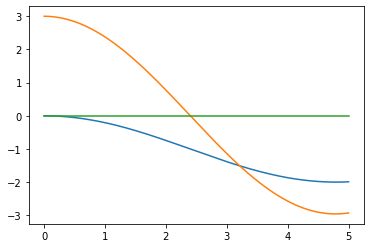

In [33]:
print('Trajectories of box versus time')
N = len(traj[0])
plt.plot(np.linspace(0, duration, N), traj[0])
plt.plot(np.linspace(0, duration, N), traj[1])
plt.plot(np.linspace(0, duration, N), traj[2])
plt.show()

Trajectories of jack versus time


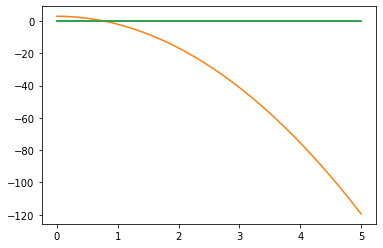

In [34]:
print('Trajectories of jack versus time')
plt.plot(np.linspace(0, duration, N), traj[3])
plt.plot(np.linspace(0, duration, N), traj[4])
plt.plot(np.linspace(0, duration, N), traj[5])
plt.show()

### Simualte with impacts.

In [35]:
phi, checkImpactIdx = phi_impact(q0)
phi_dummy = phi.subs(dummy_subs)
orgPhi = phi_dummy.subs({q_dummy[0]:q0[0], q_dummy[1]:q0[1], q_dummy[2]:q0[2], 
                         q_dummy[3]:q0[3], q_dummy[4]:q0[4], q_dummy[5]:q0[5], 
                        qdot_dummy[0]:q0[6], qdot_dummy[1]:q0[7], qdot_dummy[2]:q0[8],
                        qdot_dummy[3]:q0[9], qdot_dummy[4]:q0[10], qdot_dummy[5]:q0[11]})
print("orgPhi = ", orgPhi.evalf(3))

orgPhi =  Matrix([[3.40, 2.20, 2.80, 2.80, 2.80, 2.80, 3.40, 2.20]])


In [36]:
def impact_condition(s, orgPhi):
    """
    Checks whether impact occurs based on sign change of phi. 
    """
    phi, checkImpactIdx = phi_impact(s)
    phi_dummy = phi.subs(dummy_subs)
    phi_num = phi.subs({q[0]:s[0], q[1]:s[1], q[2]:s[2], q[3]:s[3], q[4]:s[4], q[5]:s[5], 
                        qdot[0]:s[6], qdot[1]:s[7], qdot[2]:s[8],
                        qdot[3]:s[9], qdot[4]:s[10], qdot[5]:s[11]})

    for count, single_phi in enumerate(orgPhi):
        if phi_num[count]/orgPhi[count] < 0: return count, True
        
    # There may be a situation when impact happens but sign of phi does 
    # not change due to change of velocity directions. This special case
    # should be captured and returned by phi_impact(s). 
    if not checkImpactIdx == -1: return checkImpactIdx, True 
    else: return -1, False


In [37]:
impactXb = []
impactYb = []
impactThetab = []
impactXj = []
impactYj = []
impactThetaj = []
impactXbdot = []
impactYbdot = []
impactThetabdot = []
impactXjdot = []
impactYjdot = []
impactThetajdot = []
impactIdx = 0
s_before = None
lastVals = np.zeros(8)
while True:
    for idx, tmp in enumerate(traj[0]):
        s = np.array([traj[0][idx], traj[1][idx], traj[2][idx], traj[3][idx], traj[4][idx], traj[5][idx],
                    traj[6][idx], traj[7][idx], traj[8][idx], traj[9][idx], traj[10][idx], traj[11][idx], 
                    traj[12][idx]])
        indexPhi, impact_result = impact_condition(s, orgPhi)
        if impact_result: break
        impactXb.append(s[0])
        impactYb.append(s[1])
        impactThetab.append(s[2])
        impactXj.append(s[3])
        impactYj.append(s[4])
        impactThetaj.append(s[5])
        impactXbdot.append(s[6])
        impactYbdot.append(s[7])
        impactThetabdot.append(s[8])
        impactXjdot.append(s[9])
        impactYjdot.append(s[10])
        impactThetajdot.append(s[11])
        idx -= 1
    s_before = np.array([traj[0][idx], traj[1][idx], traj[2][idx], traj[3][idx], traj[4][idx], 
                         traj[5][idx], traj[6][idx], traj[7][idx], traj[8][idx], traj[9][idx], 
                         traj[10][idx], traj[11][idx], traj[12][idx]])
    impactIdx = impactIdx + idx
    print('@ impact, length of impact traj: ', len(impactXj))
    phi = phi_impact(s_before)
    qdot_after, phiIndexFromUpdate, lastVals = impact_update(s_before, lastVals)
    indexPhi = phiIndexFromUpdate
    print('@ impact qdot_after = ', qdot_after)
    q0 =np.array([s_before[0],
                  s_before[1],
                  s_before[2],
                  s_before[3],
                  s_before[4],
                  s_before[5],
                  qdot_after[0],
                  qdot_after[1],
                  qdot_after[2],
                  qdot_after[3],
                  qdot_after[4],
                  qdot_after[5],
                  s_before[12]])
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("@ impact, new q0 = ", q0)
    phi, checkImpactIdx = phi_impact(q0)
    if len(impactXj) >= duration*200: break
    phi_dummy = phi.subs(dummy_subs)
    orgPhi = phi_dummy.subs({q_dummy[0]:q0[0], q_dummy[1]:q0[1], q_dummy[2]:q0[2], 
                             q_dummy[3]:q0[3], q_dummy[4]:q0[4], q_dummy[5]:q0[5], 
                            qdot_dummy[0]:q0[6], qdot_dummy[1]:q0[7], qdot_dummy[2]:q0[8],
                            qdot_dummy[3]:q0[10], qdot_dummy[4]:q0[9], qdot_dummy[5]:q0[11]})
    if not len(impactXj) >= duration*200 - 200: newDuration = 1
    else: newDuration = duration-(len(impactXj)*0.005)
    if newDuration <= 0.005: newDuration = 0.005
    traj = simulate(dyn, q0, [0, newDuration], 0.005, integrate) 
    print('@impact, shape of new traj: ', traj.shape)
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

@ impact, length of impact traj:  0
@ impact update, actually not an impact #1
@ impact qdot_after =  [-0.00214285 -0.00642856  0.          0.         -0.049       0.
  0.        ]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
@ impact, new q0 =  [-5.35713807e-06  2.99998393e+00  0.00000000e+00  0.00000000e+00
  2.99987750e+00  0.00000000e+00 -2.14285332e-03 -6.42855995e-03
  0.00000000e+00  0.00000000e+00 -4.90000000e-02  0.00000000e+00
  5.00000000e-03]
@impact, shape of new traj:  (13, 200)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
@ impact, length of impact traj:  142
@ impact update, updating
@ impact qdot_after =  [-0.2972697701517918 -0.8908805466819242 -0.073236 0 7.0480 0 56.416]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
@ impact, new q0 =  [-0.10904386280300195 2.6730910026706627 0.0 0.0 0.4598399999999988 0.0
 -0.2972697701517918 -0.8908805466819242 -0.073236 0 7.0480 0 0.715]
@impact, shape of new traj:  (13, 200)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
@ impact, length of impact

Trajectories of box versus time


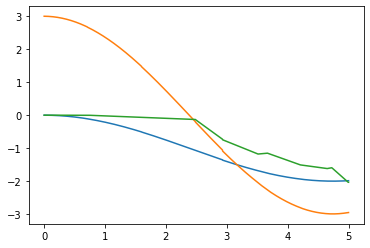

In [38]:
print('Trajectories of box versus time')
N = len(impactXb)
plt.plot(np.linspace(0, duration, N), impactXb)
plt.plot(np.linspace(0, duration, N), impactYb)
plt.plot(np.linspace(0, duration, N), impactThetab)
plt.show()

Trajectories of jack versus time


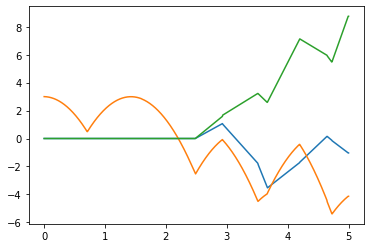

In [39]:
print('Trajectories of jack versus time')
plt.plot(np.linspace(0, duration, N), impactXj)
plt.plot(np.linspace(0, duration, N), impactYj)
plt.plot(np.linspace(0, duration, N), impactThetaj)
plt.show()

In [44]:
impactTraj = np.array([impactXb,impactYb, impactThetab, impactXj, impactYj, impactThetaj,
                       impactXbdot, impactYbdot, impactThetabdot, impactXjdot, impactYjdot, impactThetajdot])
animate(impactTraj,L=L,W=W,R=R,T=duration)

### Check Hamiltonian without considering x and y forces.

In [41]:
func_H = sym.lambdify([*q, *qdot], H, 'sympy')

In [42]:
H_arr = []
for t in np.arange(N):
    xb = 0
    yb = 0
    thetab = impactTraj[2][t]
    xj = impactTraj[3][t]
    yj = impactTraj[4][t]
    thetaj = impactTraj[5][t]
    dxb = 0
    dyb = 0
    dthetab = impactTraj[8][t]
    dxj = impactTraj[9][t]
    dyj = impactTraj[10][t]
    dthetaj = impactTraj[11][t]
    H_arr.append(func_H(xb, yb, thetab, xj, yj, thetaj, dxb, dyb, dthetab, dxj, dyj, dthetaj))
print('shape of H: ', len(H_arr))

shape of H:  1000


Trajectories of Hamiltonian versus time


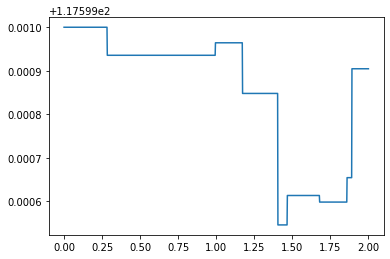

In [43]:
print('Trajectories of Hamiltonian versus time')
plt.plot(np.linspace(0, 2, N), H_arr)
plt.show()